# Exercício-Programa 3: Mais Fractais

## 1. *Parsing* dos relatórios

Essa seção do notebook realiza o *parsing* dos relatórios gerados por `run_measurements.sh`, concatena todos resultados em um único dataframe e gera o `.csv` final.

In [2]:
def get_file_paths(dir_path='measurements'):
    import os

    # reports = ['sequential_logs.txt', 'parallel_logs.txt']
    reports = ['sequential_logs.txt', 'parallel_logs.txt', 
               'smpi_heterog_logs.txt', 'smpi_homog_10_lat_logs.txt',
               'smpi_homog_100_lat_logs.txt', 'smpi_homog_500_lat_logs.txt']
    
    paths = []
    for report in reports:
        paths.append(os.path.join(dir_path, report))

    return paths

In [3]:
import numpy as np
import pandas as pd
import re
import math

names = {
    'sequential_julia': 'sequential',
    '1D_parallel_julia': 'mpi',
    'smpi_heterog': 'smpi',
    'smpi_homog_10_lat': 'smpi',
    'smpi_homog_100_lat': 'smpi',
    'smpi_homog_500_lat': 'smpi'
}

def parse_simple_reports(reports):
    regex = r"\./(\w+)\.o (\d+) \nTempo de execução: ([0-9\.]+) segundos"
    
    data = []

    for report in reports:
        match = re.match(regex, report)
        if match:
            executable, n, elapsed_time = match.groups()
            data.append({
                "executable": executable,
                "n": int(n),
                "elapsed_time": float(elapsed_time)
            })

    df = pd.DataFrame(data)
    df['version'] = df['executable'].replace(names)

    return df

def parse_smpi_reports(reports):
    regex = r"\./(\w+) (\d+) (\d+)\nTempo de execução dos processos:\n((?:Processo \d+: [0-9\.]+ segundos\n?)+)"
    
    data = []

    for report in reports:
        match = re.match(regex, report)
        if match:
            executable, n, n_procs, list_procs = match.groups()
            process_times = re.findall(r"Processo \d+: ([0-9\.]+) segundos", list_procs)
            process_times = [float(t) for t in process_times]
    
            row = {
                "executable": executable,
                "n": int(n),
                "n_procs": int(n_procs),
            }
    
            for i, time in enumerate(process_times):
                row[f'process_{i}_elapsed_time'] = time

            max_time = max(process_times)
            row['max_proc_id'] = process_times.index(max_time)
            row['elapsed_time'] = max_time
    
            data.append(row)

    df = pd.DataFrame(data)
    df['version'] = df['executable'].replace(names)

    return df

In [4]:
def read_and_parse_reports(file_paths):
    simple_reports = open(file_paths[0], 'r').read()

    smpi_reports = ""
    for path in file_paths[1:]:
        smpi_reports += open(path, 'r').read()
    
    simple_reports = simple_reports.split("\n\n")
    smpi_reports = smpi_reports.split("\n\n")

    simple_df = parse_simple_reports(simple_reports)
    smpi_df = parse_smpi_reports(smpi_reports)

    df = pd.concat([simple_df, smpi_df], ignore_index=True)
    return df

In [5]:
paths = get_file_paths()
dataframes = []
raw_data = read_and_parse_reports(paths)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 70 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   executable               2159 non-null   object 
 1   n                        2159 non-null   int64  
 2   elapsed_time             2159 non-null   float64
 3   version                  2159 non-null   object 
 4   n_procs                  2079 non-null   float64
 5   process_0_elapsed_time   2079 non-null   float64
 6   process_1_elapsed_time   2079 non-null   float64
 7   max_proc_id              2079 non-null   float64
 8   process_2_elapsed_time   1680 non-null   float64
 9   process_3_elapsed_time   1680 non-null   float64
 10  process_4_elapsed_time   1280 non-null   float64
 11  process_5_elapsed_time   1280 non-null   float64
 12  process_6_elapsed_time   1280 non-null   float64
 13  process_7_elapsed_time   1280 non-null   float64
 14  process_8_elapsed_time  

In [7]:
raw_data.sample(5)

,executable,n,elapsed_time,version,n_procs,process_0_elapsed_time,process_1_elapsed_time,max_proc_id,process_2_elapsed_time,process_3_elapsed_time,...,process_54_elapsed_time,process_55_elapsed_time,process_56_elapsed_time,process_57_elapsed_time,process_58_elapsed_time,process_59_elapsed_time,process_60_elapsed_time,process_61_elapsed_time,process_62_elapsed_time,process_63_elapsed_time
2115,smpi_homog_500_lat,5000,1.657435,smpi,8.0,0.520819,0.717408,4.0,1.363745,1.655139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1027,smpi_homog_10_lat,500,0.011581,smpi,16.0,0.002557,0.002976,8.0,0.004096,0.004601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,smpi_homog_500_lat,2500,0.758503,smpi,4.0,0.307329,0.757601,2.0,0.758503,0.310220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,smpi_homog_10_lat,500,0.009608,smpi,16.0,0.004275,0.003432,7.0,0.003308,0.004501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1188,smpi_homog_10_lat,2500,0.760321,smpi,4.0,0.307417,0.756745,2.0,0.760321,0.308054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dataframe = raw_data.query('executable == "sequential_julia" or executable == "1D_parallel_julia"')

In [9]:
dataframe.describe()

,n,elapsed_time,n_procs,process_0_elapsed_time,process_1_elapsed_time,max_proc_id,process_2_elapsed_time,process_3_elapsed_time,process_4_elapsed_time,process_5_elapsed_time,...,process_54_elapsed_time,process_55_elapsed_time,process_56_elapsed_time,process_57_elapsed_time,process_58_elapsed_time,process_59_elapsed_time,process_60_elapsed_time,process_61_elapsed_time,process_62_elapsed_time,process_63_elapsed_time
count,560.000000,560.000000,480.000000,480.000000,480.000000,480.000000,400.000000,400.000000,320.000000,320.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,2250.000000,1.470493,21.000000,0.610925,0.850082,9.964583,0.656865,0.475656,0.480517,0.470874,...,0.222362,0.202286,0.233424,0.240079,0.219044,0.198029,0.195305,0.180208,0.194233,0.170004
std,1751.564596,2.192165,21.679002,1.449451,1.737806,11.137441,1.281785,0.787920,0.826904,0.724387,...,0.291821,0.277768,0.306374,0.331426,0.287504,0.270908,0.251340,0.238228,0.259451,0.228198
min,500.000000,0.017600,2.000000,0.000963,0.000992,0.000000,0.001058,0.001064,0.001132,0.001292,...,0.000964,0.001126,0.001217,0.001187,0.001036,0.000958,0.000967,0.000897,0.000863,0.000853
25%,875.000000,0.095219,4.000000,0.019305,0.023574,2.000000,0.024956,0.023703,0.019797,0.023449,...,0.004426,0.005007,0.008315,0.004415,0.005269,0.003797,0.003823,0.004419,0.003141,0.004542
50%,1750.000000,0.400168,12.000000,0.120440,0.167205,5.000000,0.156785,0.126657,0.124315,0.118655,...,0.036153,0.037644,0.034097,0.078098,0.049087,0.035686,0.041961,0.032029,0.038781,0.039544
75%,3125.000000,2.132140,32.000000,0.499401,0.661797,15.000000,0.647211,0.640444,0.669607,0.629123,...,0.285620,0.290428,0.354298,0.283461,0.264491,0.290237,0.267408,0.239428,0.257928,0.209042
max,5000.000000,8.721428,64.000000,7.213635,7.230625,42.000000,5.564192,3.334478,3.332272,2.660714,...,0.995288,0.976030,1.076198,1.135254,1.002846,0.856153,0.781058,0.749158,0.801561,0.777988


In [10]:
%%script echo skipping

raw_data.to_csv('results.csv', index=False)

skipping


## 2. Análise descritiva

### Experimentos com MPICH

In [11]:
dataframe.groupby("executable")["elapsed_time"].mean()

executable
1D_parallel_julia    1.249294
sequential_julia     2.797689
Name: elapsed_time, dtype: float64

In [12]:
dataframe.groupby("executable")["elapsed_time"].median()

executable
1D_parallel_julia    0.380623
sequential_julia     1.243762
Name: elapsed_time, dtype: float64

In [13]:
df_seq = dataframe[dataframe['executable'] == 'sequential_julia']
df_mpi = dataframe[dataframe['executable'] == '1D_parallel_julia']

In [14]:
from utils.plots import plot_mean_ci_by_exec

In [15]:
from utils.plots import plot_side_by_side

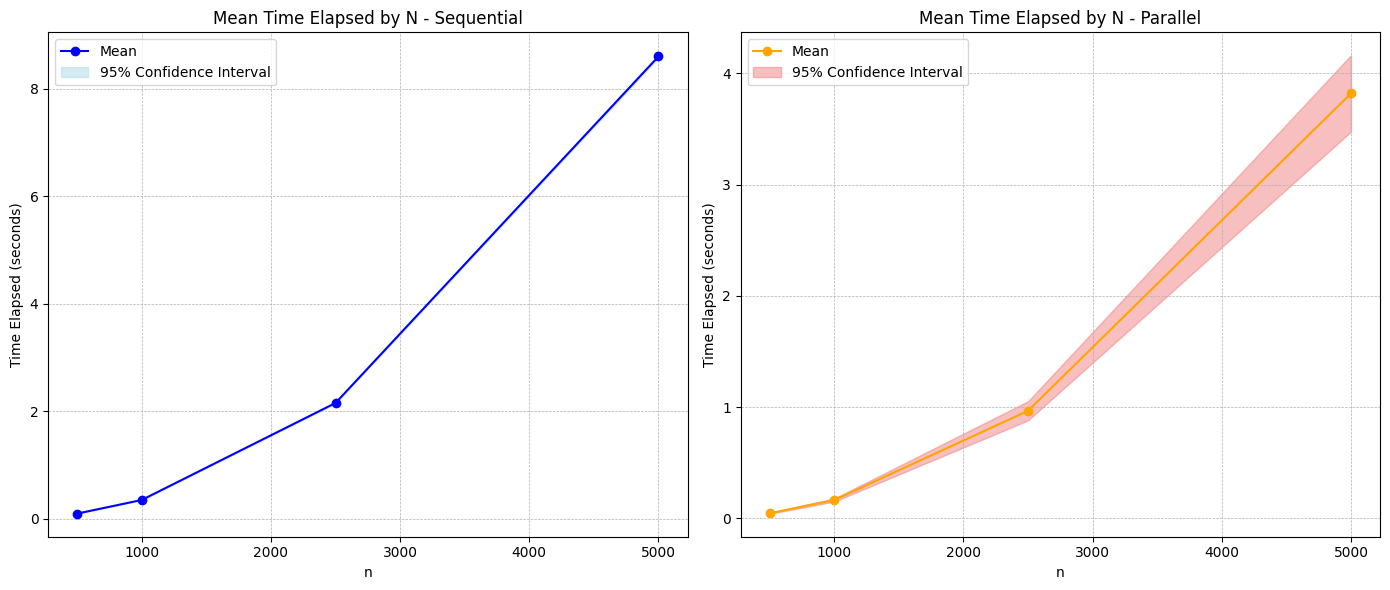

In [16]:
plot_side_by_side(df_seq, df_mpi, title1='Mean Time Elapsed by N - Sequential', title2='Mean Time Elapsed by N - Parallel', group_by="n")

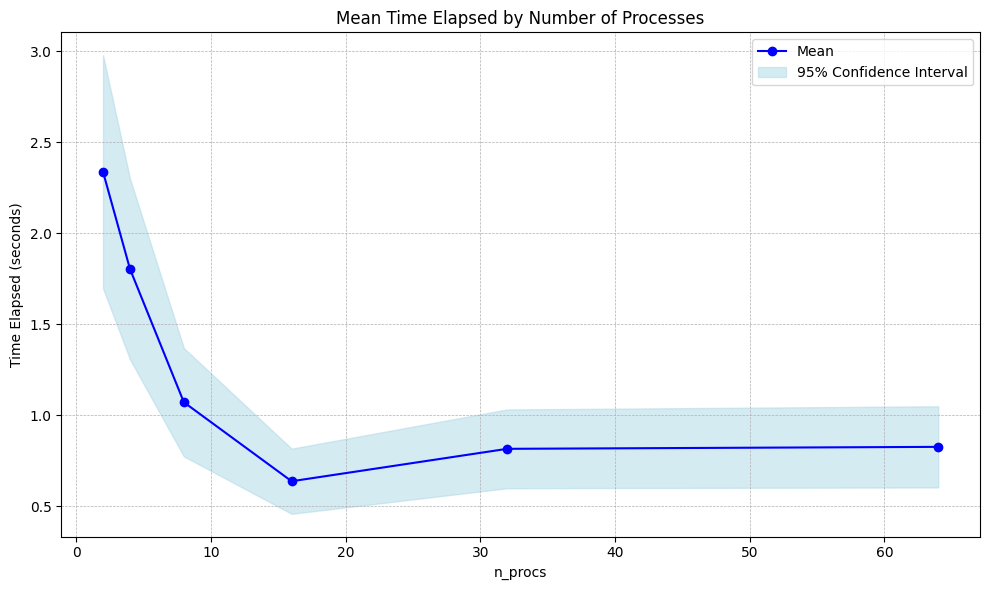

In [17]:
plot_mean_ci_by_exec(df_mpi, title="Mean Time Elapsed by Number of Processes", group_by='n_procs')

#### Cálculo do *speedup*

In [18]:
speedup = df_seq["elapsed_time"].mean()/df_mpi["elapsed_time"].mean()
speedup

np.float64(2.239416065261299)

Logo, o speedup da versão paralelizada vs versão sequencial foi de aproximadamente **2.24x**.

#### Análise de eficiência

Selecionando todas execuções para `n=5000`:

In [19]:
df = dataframe.loc[(dataframe['n'] == 5000) & (dataframe['executable'] == '1D_parallel_julia')]

In [20]:
df.groupby("n_procs")["elapsed_time"].mean()

n_procs
2.0     7.157784
4.0     5.538825
8.0     3.316751
16.0    1.988573
32.0    2.420791
64.0    2.492902
Name: elapsed_time, dtype: float64

In [21]:
df.groupby("n_procs")["elapsed_time"].median()

n_procs
2.0     7.156738
4.0     5.540824
8.0     3.316941
16.0    1.989621
32.0    2.356065
64.0    2.488144
Name: elapsed_time, dtype: float64

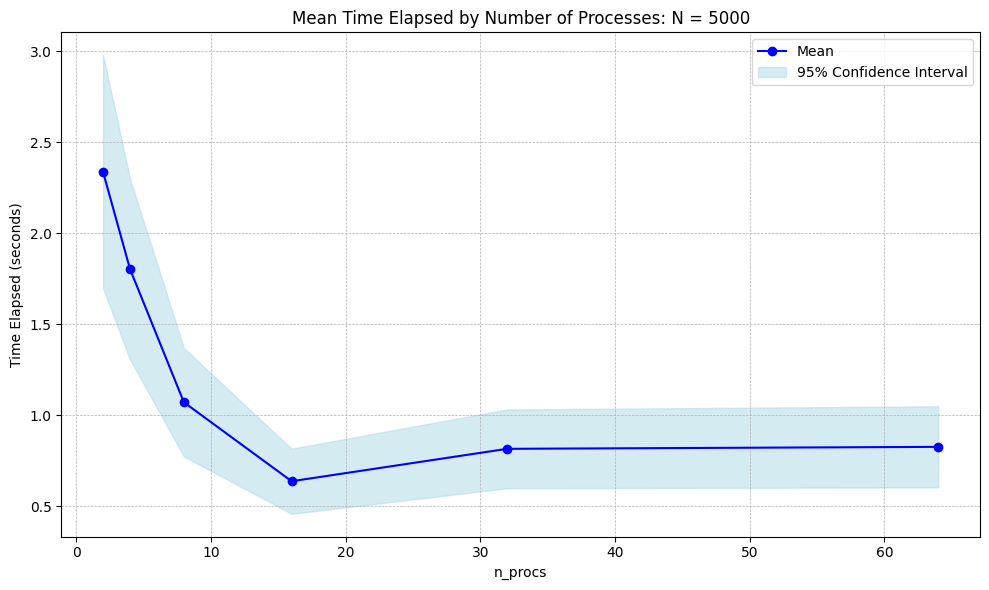

In [22]:
plot_mean_ci_by_exec(df_mpi, title="Mean Time Elapsed by Number of Processes: N = 5000", group_by='n_procs')

Podemos ver que a maior eficiência ocorre para 16 processos e se estabiliza a partir desse mesmo valor.

### Experimentos com SimGrid

#### Experimentos com cluster heterogêneo:

In [23]:
df_smpi_heterog = raw_data[raw_data['executable'] == 'smpi_heterog']

In [24]:
df_smpi_homog = raw_data[raw_data['executable'] == 'smpi_homog_10_lat']

In [25]:
df_smpi_heterog.groupby("n_procs")["elapsed_time"].mean()

n_procs
2.0     1.415377
4.0     1.000423
8.0     0.547377
16.0    0.279488
32.0    0.142115
Name: elapsed_time, dtype: float64

In [26]:
df_smpi_homog.groupby("n_procs")["elapsed_time"].mean()

n_procs
2.0     1.397941
4.0     0.993813
8.0     0.546870
16.0    0.278768
32.0    0.142394
Name: elapsed_time, dtype: float64

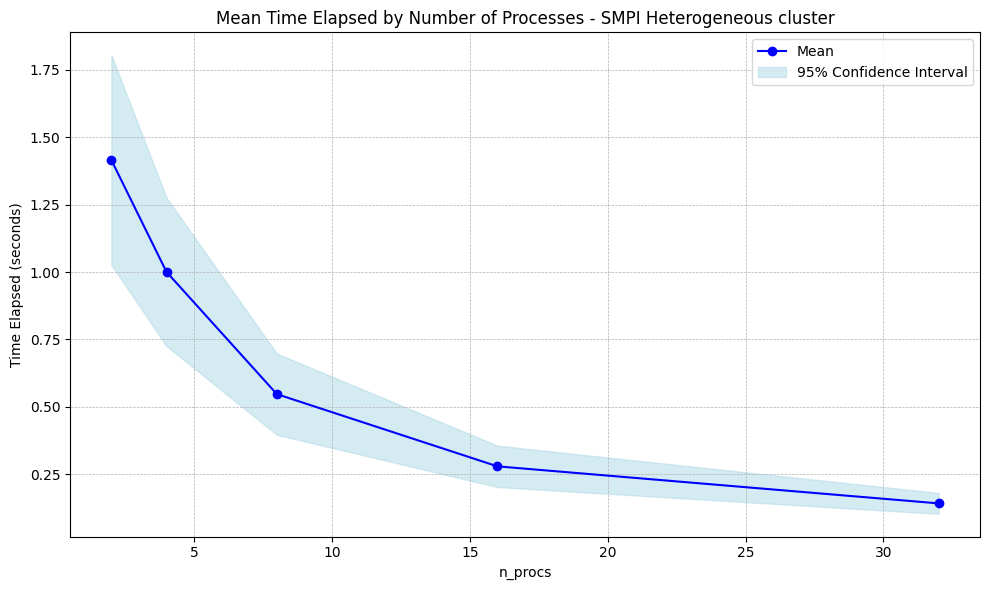

In [40]:
plot_mean_ci_by_exec(df_smpi_heterog, title="Mean Time Elapsed by Number of Processes - SMPI Heterogeneous cluster", group_by='n_procs')

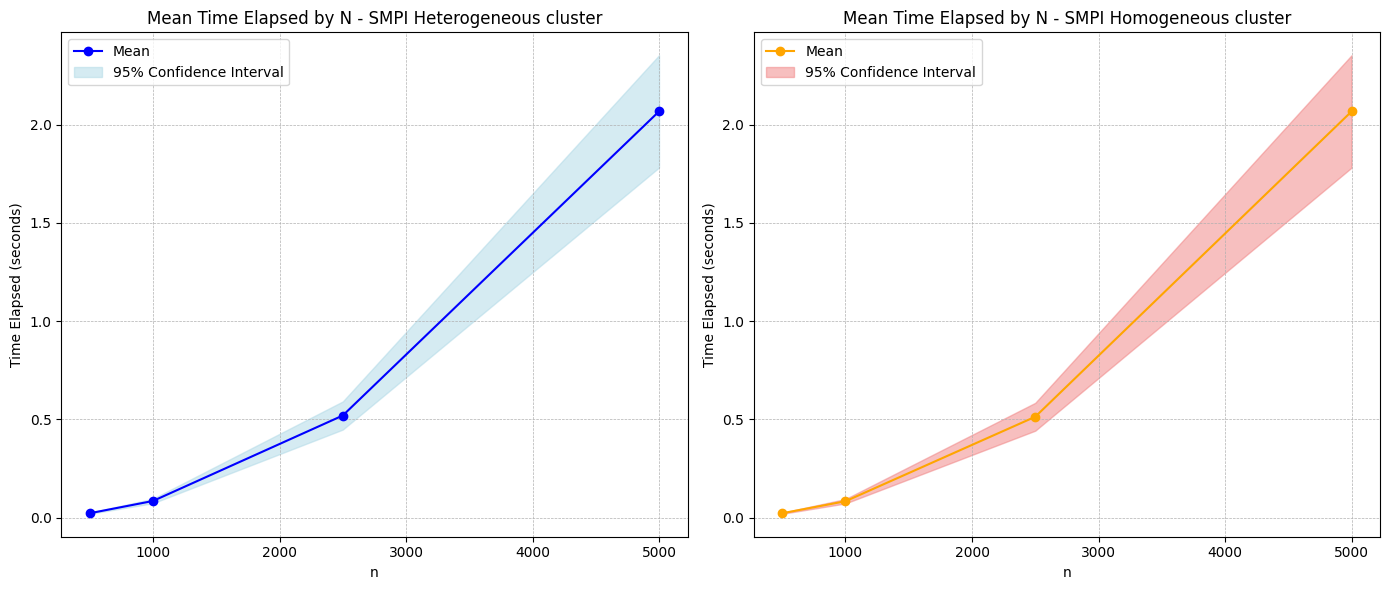

In [27]:
plot_side_by_side(df_smpi_heterog, df_smpi_homog, title1='Mean Time Elapsed by N - SMPI Heterogeneous cluster', title2='Mean Time Elapsed by N - SMPI Homogeneous cluster', group_by="n")

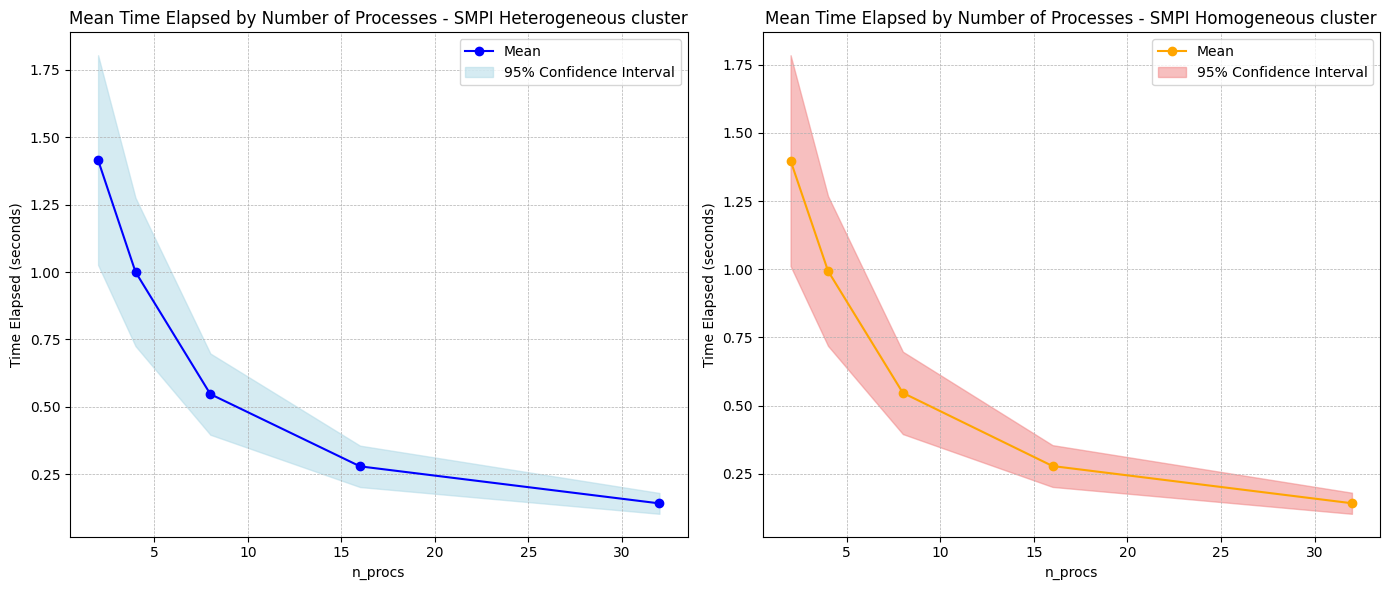

In [28]:
plot_side_by_side(df_smpi_heterog, df_smpi_homog, title1='Mean Time Elapsed by Number of Processes - SMPI Heterogeneous cluster', title2='Mean Time Elapsed by Number of Processes - SMPI Homogeneous cluster', group_by="n_procs")

In [29]:
speedup = df_smpi_heterog["elapsed_time"].mean()/df_smpi_homog["elapsed_time"].mean()
speedup

np.float64(1.004685352735828)

#### Experimentos com cluster homogêneo:

In [30]:
df_smpi_homog_100_lat = raw_data[raw_data['executable'] == 'smpi_homog_100_lat']
df_smpi_homog_100_lat.groupby("n_procs")["elapsed_time"].median()

n_procs
2.0     0.625920
4.0     0.445433
8.0     0.245095
16.0    0.125497
32.0    0.064397
Name: elapsed_time, dtype: float64

In [31]:
df_smpi_homog_500_lat = raw_data[raw_data['executable'] == 'smpi_homog_500_lat']
df_smpi_homog_500_lat.groupby("n_procs")["elapsed_time"].median()

n_procs
2.0     0.620603
4.0     0.441418
8.0     0.245101
16.0    0.125462
32.0    0.065668
Name: elapsed_time, dtype: float64

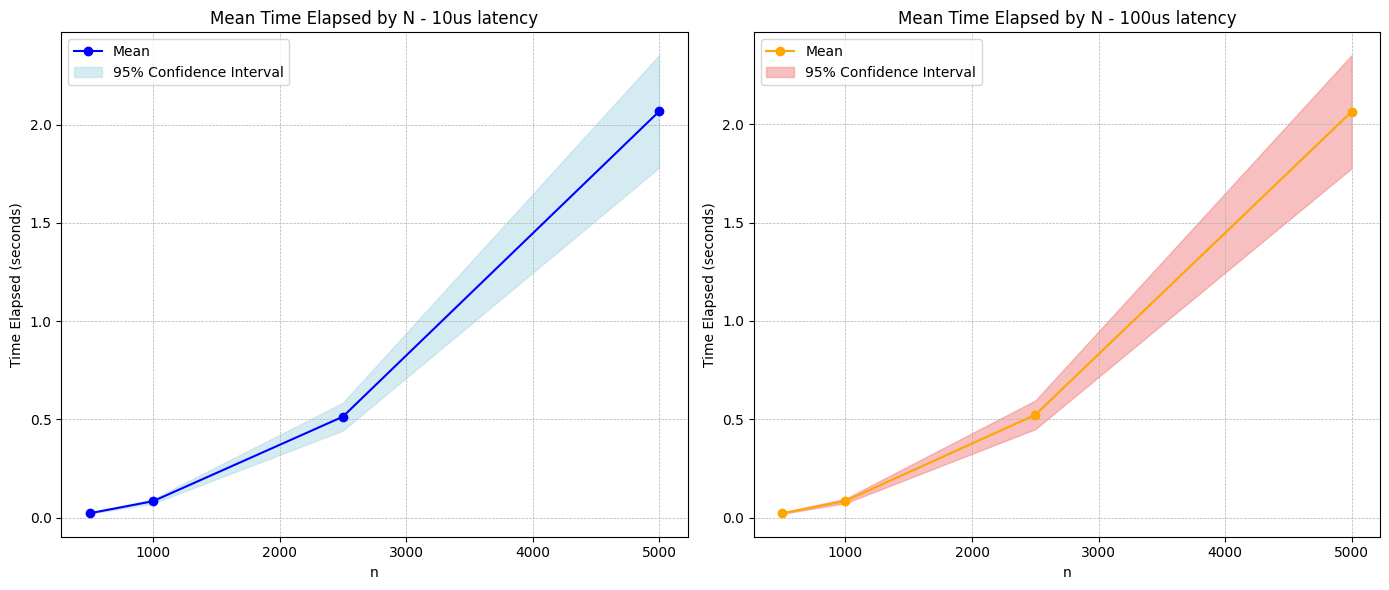

In [32]:
plot_side_by_side(df_smpi_homog, df_smpi_homog_100_lat, title1='Mean Time Elapsed by N - 10us latency', title2='Mean Time Elapsed by N - 100us latency', group_by="n")

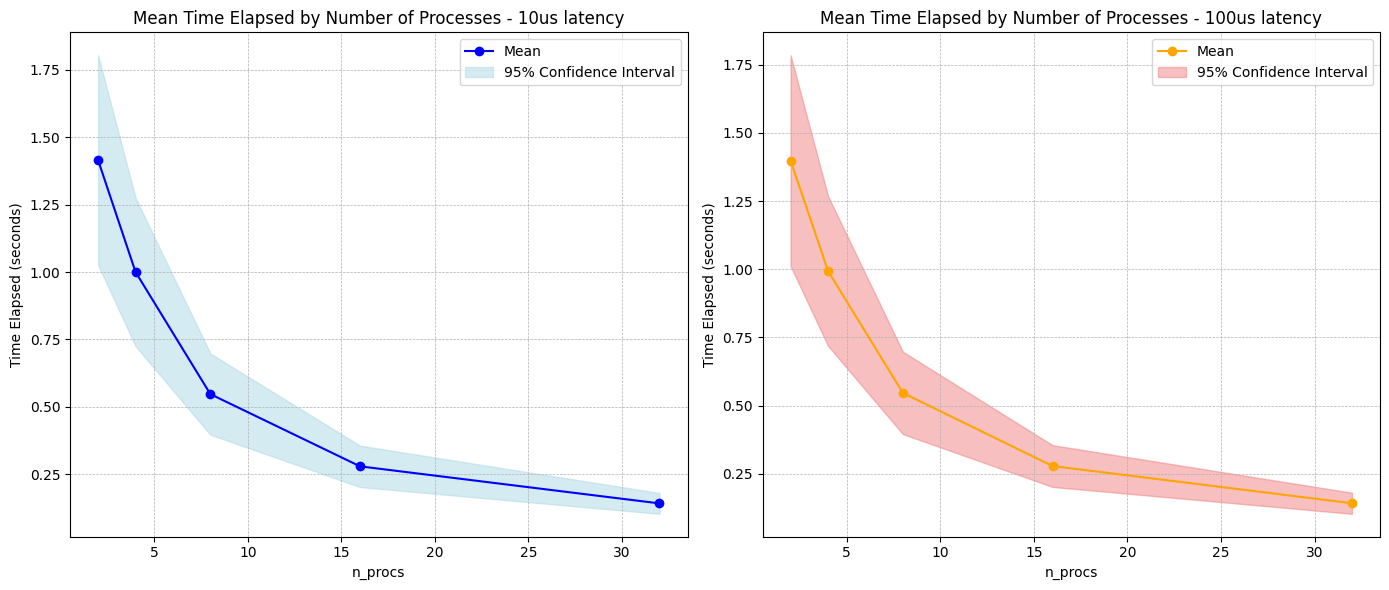

In [33]:
plot_side_by_side(df_smpi_heterog, df_smpi_homog, title1='Mean Time Elapsed by Number of Processes - 10us latency', title2='Mean Time Elapsed by Number of Processes - 100us latency', group_by="n_procs")

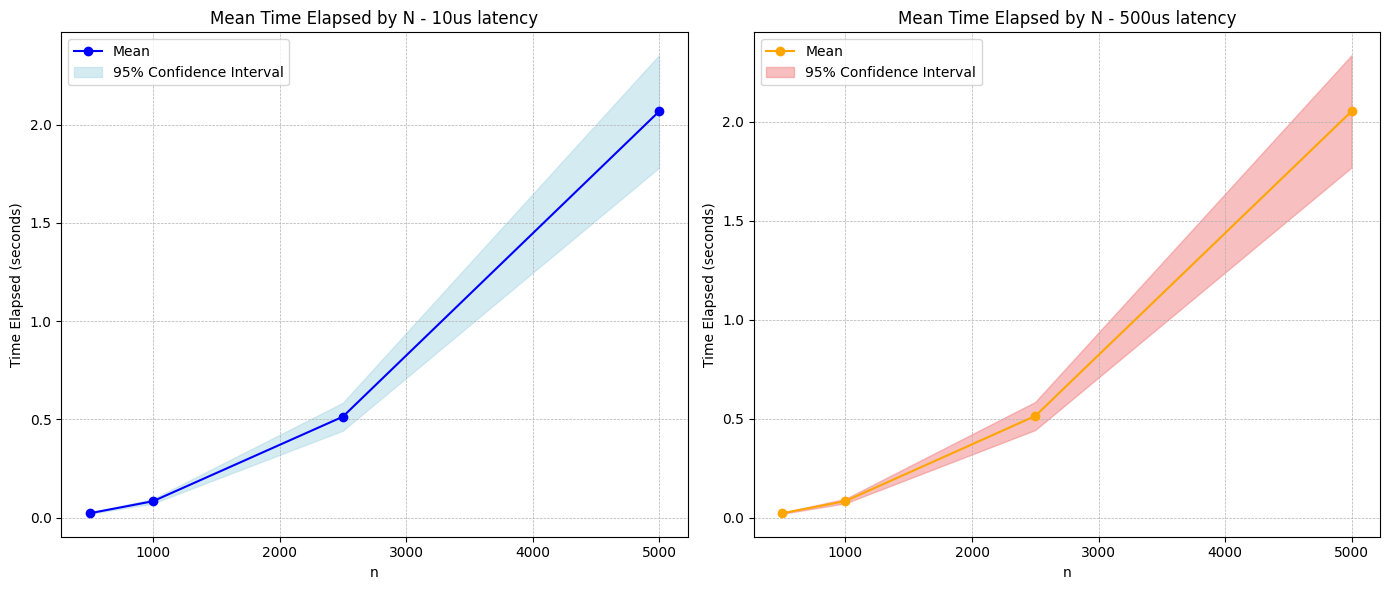

In [34]:
plot_side_by_side(df_smpi_homog, df_smpi_homog_500_lat, title1='Mean Time Elapsed by N - 10us latency', title2='Mean Time Elapsed by N - 500us latency', group_by="n")

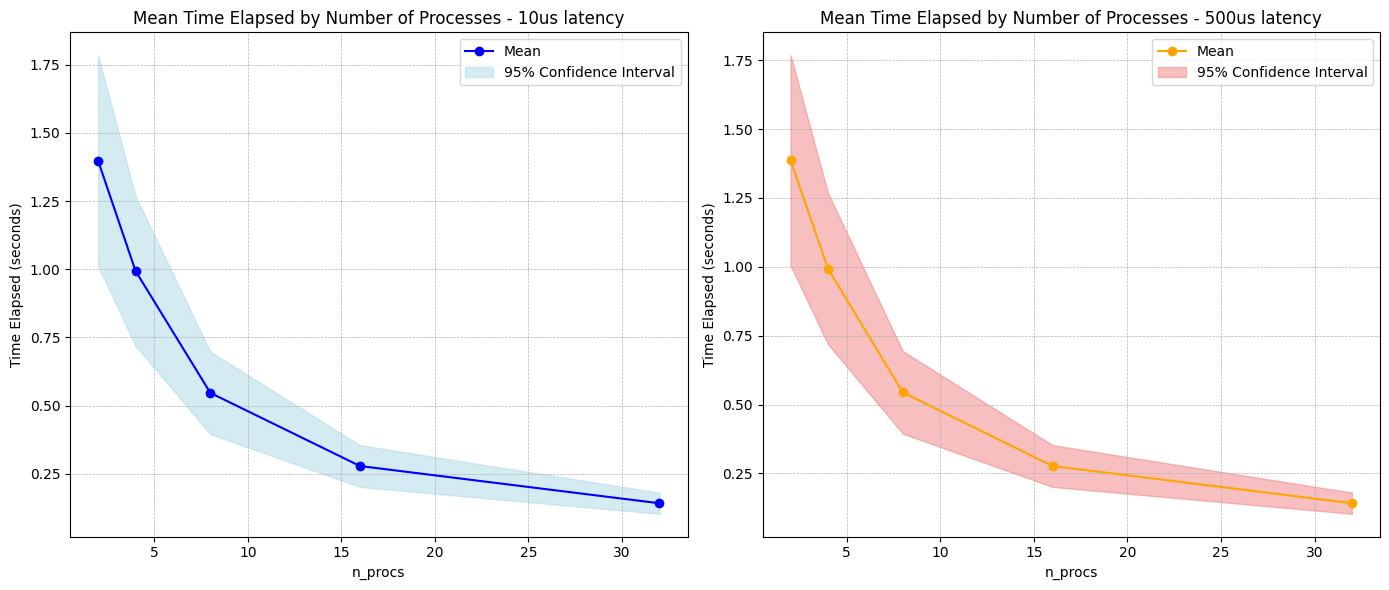

In [35]:
plot_side_by_side(df_smpi_homog, df_smpi_homog_500_lat, title1='Mean Time Elapsed by Number of Processes - 10us latency', title2='Mean Time Elapsed by Number of Processes - 500us latency', group_by="n_procs")

In [37]:
df_smpi_homog["elapsed_time"].mean()/df_smpi_homog_100_lat["elapsed_time"].mean()

np.float64(0.9984293756357593)

In [38]:
df_smpi_homog["elapsed_time"].mean()/df_smpi_homog_500_lat["elapsed_time"].mean()

np.float64(1.0051140758125052)